In [16]:
"""Temporary fix for importing modules from parent directory"""
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [17]:
from varitop.misc import euler_rule
from varitop.integrator import DelIntegrator as DI
from varitop.model import DarliModel

from matplotlib import pyplot as plt
from tqdm import tqdm
import casadi as cs
import numpy as np

In [18]:
urdf_path = '../assets/urdf/2link_robot.urdf'
t0, tf, steps = 0.0, 3.0, 200
dt = (tf - t0) / steps

In [19]:
di = DI()
di.model = DarliModel(urdf_path)
di.rule = euler_rule

In [20]:
q = cs.MX.sym('q', di.nq)
dq = cs.MX.sym('dq', di.nq)
u = cs.MX.sym('u', di.nu)
f = cs.Function('f', [q, dq, u], [u])

di.add_generalized_forces([f])

In [54]:
q_0 = np.array([0, 0])
us = np.full((steps, di.nu), [5, 3])

In [55]:
qs_sol = np.zeros((steps, 2))
qs_sol[0] = q_0
qs_sol[1] = q_0

for i in tqdm(range(2, steps)):
    q0 = qs_sol[i - 2]
    q1 = qs_sol[i - 1]

    qs_sol[i] = di.step(q0, q1, dt, us[i])

100%|██████████| 198/198 [00:00<00:00, 646.96it/s]


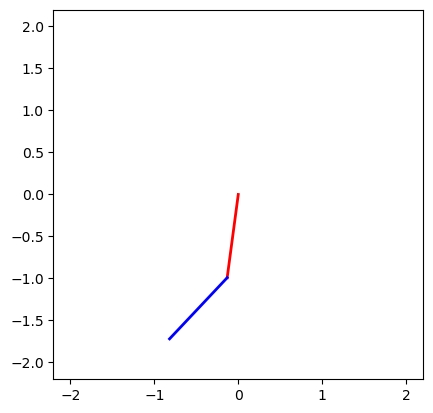

In [56]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set_aspect("equal")

ax.set_xlim(-2.2, 2.2)
ax.set_ylim(-2.2, 2.2)

ln1 = ax.plot([], [], "r-", lw=2)[0]
ln2 = ax.plot([], [], "b-", lw=2)[0]


def update(frame):
    # Rotate the basis vectors
    phi1 = qs_sol[frame, 0]
    phi2 = qs_sol[frame, 1]

    A = np.array([-np.sin(phi1), -np.cos(phi1)])
    B = np.array([-np.sin(phi1) - np.sin(phi2), -np.cos(phi1) - np.cos(phi2)])

    global ln1, ln2
    ln1.set_data([0, A[0]], [0, A[1]])
    ln2.set_data([A[0], B[0]], [A[1], B[1]])


# Create the animation
animation = FuncAnimation(fig, update, frames=len(qs_sol), interval=tf * 1000 / steps)

# Save the animation as a GIF using Pillow writer
animation.save("evolution_history_l2.gif")

# Display the animation
plt.show()